# E10s testing for Beta 52 week 3: Main analysis

(This covers data from 2017-02-08 to 2017-02-15 on Beta 52)

## Data processing

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import plotly.plotly as py
import IPython
import pyspark.sql.functions as fun
import pyspark.sql.types as st
from pyspark.sql import Row
from collections import Counter

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)
seaborn.set_style('whitegrid')

from operator import add
pd.set_option("display.max_rows", None)

/home/hadoop/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/histogram-whitelists.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
%%bash
pip install colour

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from colour import Color

In [4]:
sc.defaultParallelism

640

In [5]:
sc.version

u'1.6.1'

In [6]:
def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    """ The comparison metric for histograms. """
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def make_group_histogram(group_data):
    """ Combine separate client histograms into a single group histogram, normalizing bin counts
        to relative frequencies.       
    """
    ## Check for histograms with 0 counts.
    client_totals = group_data.map(lambda x: x.sum())
    group_data = group_data[client_totals > 0]
    ## Convert frequency counts to relative frequency for each client histogram.
    group_data = group_data.map(lambda x: x/x.sum())
    ## Merge the group's client histograms by adding up the frequencies over all clients
    ## in the group, separately for each bin.
    group_data = group_data.sum()
    ## Convert the merged bin frequencies to relative percentages.
    group_data = 100 * group_data / group_data.sum()
    return group_data
    

def compare_histogram(histogram, e10s_addons, none10s_addons, e10s_std=None, none10s_std=None,
                      include_diff=True, include_diff_in_diff=True, did_separate_plot=True):
    """ Compare an e10s histogram to a non-e10s one, and graph the results.
        
        Plots the two histograms overlaid on the same graph, and prints a p-value
        for testing whether they are different. If 'include_diff' is True, also
        draw a plot of the frequency differences for each bin.
        
        If 'include_diff_in_diff' is True and data is supplied, include a plot of
        differences between addon cohort differences and non-addon cohort differences.
    """
    eTotal = make_group_histogram(e10s_addons)
    nTotal = make_group_histogram(none10s_addons)
    
    if include_diff:
        if include_diff_in_diff and did_separate_plot:
            fig, (ax, diff_ax, diff_diff_ax) = plt.subplots(3, sharex=True, figsize=(16,10), 
                                                            gridspec_kw={"height_ratios": [2,2,1]})
        else:
            fig, (ax, diff_ax) = plt.subplots(2, sharex=True)
    else:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        
    fig.subplots_adjust(hspace=0.3)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width,
                position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non-e10s", ax=ax2, width=width,
                position=1, grid=False, ylim=ax.get_ylim())
    
    ## Combine legend info from both Axes.
    ax_h, ax_l = ax.get_legend_handles_labels()
    ax2_h, ax2_l = ax2.get_legend_handles_labels()
    ax.legend(ax_h + ax2_h, ax_l + ax2_l, loc = 0)
 
    plt.title(histogram)
    ax.xaxis.grid(False)
    ax.set_ylabel("Frequency %")

    if include_diff:
        ## Add a second barplot of the difference in frequency for each bucket.
        #diff_ax = fig.add_subplot(2, 1, 2)
        enDiff = eTotal - nTotal
        
        has_diff_in_diff_data = (e10s_std is not None and len(e10s_std) > 0 and
                                 none10s_std is not None and len(none10s_std) > 0)
        if include_diff_in_diff and has_diff_in_diff_data:
            ## Add bin differences for between e10s/non-e10s for the no-addons cohorts.
            ## The assumption is that the difference between addons cohorts would look the same
            ## if there is no additional effect of having addons.
            eTotal_std = make_group_histogram(e10s_std)
            nTotal_std = make_group_histogram(none10s_std)
            enDiff_std = eTotal_std - nTotal_std
            ylims = (min(enDiff.min(), enDiff_std.min()) - 0.5, max(enDiff.max(), enDiff_std.max()) + 0.5)
            diff_ax2 = diff_ax.twinx()
            
            enDiff.plot(kind="bar", alpha=0.5, color="navy", label="with add-ons", ax=diff_ax, width=width,
                        position=1, ylim=ylims)
            enDiff_std.plot(kind="bar", alpha=0.5, color="gray", label="no add-ons", ax=diff_ax2, width=width,
                        position=0, grid=False, ylim=diff_ax.get_ylim())

            ## Combine legend info from both Axes.
            diff_ax_h, diff_ax_l = diff_ax.get_legend_handles_labels()
            diff_ax2_h, diff_ax2_l = diff_ax2.get_legend_handles_labels()
            leg_h = diff_ax_h + diff_ax2_h
            leg_l = diff_ax_l + diff_ax2_l
            
            if did_separate_plot:
                enDiffDiff = enDiff - enDiff_std
                enDiffDiff.plot(kind="bar", alpha=0.5, color="maroon", ax=diff_diff_ax, ylim=diff_ax.get_ylim())
                diff_diff_ax.xaxis.grid(False)
                diff_diff_ax.set_ylabel("Diff in freq %")
                diff_diff_ax.set_title("Diff between e10s/non diff with add-ons and e10s/non diff without" +
                                      " (with add-ons higher when > 0)")
            
        else:
            if include_diff_in_diff:
                ## We wanted to do the additional comparison, but there wasn't enough data.
                print("\nNo diff-in-diff comparison: one of the standard cohorts has no non-missing observations.")
            enDiff.plot(kind="bar", alpha=0.5, color="navy", label="with add-ons", ax=diff_ax)
            leg_h, leg_l = diff_ax.get_legend_handles_labels()
        
        plt.title("e10s/non-e10s difference (more e10s in bucket when > 0)")
        diff_ax.xaxis.grid(False)
        diff_ax.set_ylabel("Diff in frequency %")
        diff_ax.legend(leg_h, leg_l, loc = 0)
    
    
    # Only display at most 100 tick labels on the x axis.
    xticklabs = plt.gca().get_xticklabels()
    max_x_ticks = 100
    if len(xticklabs) > max_x_ticks:
        step_size = math.ceil(float(len(xticklabs)) / max_x_ticks)
        for i, tl in enumerate(xticklabs):
            if i % step_size != 0:
                tl.set_visible(False)
    plt.show()
    
    ## Compute a p-value for the chi-square distance between the groups' combined histograms.
    pvalue = grouped_permutation_test(chi2_distance, [e10s_addons, none10s_addons], num_samples=100)
    print("The probability that the distributions for {} (with add-ons) are differing by chance is {:.3f}."\
          .format(histogram, pvalue))

def normalize_uptime_hour(frame):
    """ Convert metrics to rates per hour of uptime. """
    frame = frame[frame["payload/simpleMeasurements/totalTime"] > 60]
    frame = 60 * 60 * frame.apply(lambda x: x / frame["payload/simpleMeasurements/totalTime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/totalTime', axis=1, inplace=True)
    return frame
    
def compare_e10s_count_histograms(pings, cohort_sizes = {}, *histogram_names, **kwargs):
    """ Read multiple count histograms from a collection of pings, and compare e10s/non-e10s for each.
    
        Treats count histograms as scalars for comparison purposes, without distinguishing between
        parent and child processes. Expects a dict containing overall cohort sizes
        for computing sample size proportions.
    """
    properties = histogram_names + ("payload/simpleMeasurements/totalTime", "e10s", "addons")
    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())
    
    e10s = frame[frame["addons"] & frame["e10s"]]
    e10s = normalize_uptime_hour(e10s)
    
    none10s = frame[frame["addons"] & ~frame["e10s"]]
    none10s = normalize_uptime_hour(none10s)
    
    include_diff_in_diff = kwargs.get("include_diff_in_diff", True)
    if include_diff_in_diff:
        e10s_std = normalize_uptime_hour(frame[~frame["addons"] & frame["e10s"]])
        none10s_std = normalize_uptime_hour(frame[~frame["addons"] & ~frame["e10s"]])        
    
    for histogram in histogram_names:
        if histogram not in none10s.columns:
            continue
        
        ## Remove the property path from the histogram name for display purposes.
        hist_name = hist_base_name(histogram)
        if type(hist_name) == list:
            ## Key was given for keyed histogram.
            hist_str = "{}/{}".format(link_to_histogram(hist_name[0]), hist_name[1])
            hist_name = hist_name[0]
        else:
            hist_str = hist_name
        ## Print a header for the block of graphs, including a link to the histogram definition.
        print_with_markdown("Comparison for count histogram {} (with add-ons):".format(hist_str))
        
        e10s_hist = e10s[histogram].dropna()
        non_e10s_hist = none10s[histogram].dropna()
        
        ## Print some information on sample sizes.
        print("{} non-e10s profiles have this histogram.".format(
                sample_size_str(len(non_e10s_hist), cohort_sizes.get("addons-set2a-control"))))
        print("{} e10s profiles have this histogram.".format(
                sample_size_str(len(e10s_hist), cohort_sizes.get("addons-set2a-test"))))
        ## If either group has no data, nothing more to do.
        if len(non_e10s_hist) == 0 or len(e10s_hist) == 0:
            continue
        
        print("")
        compare_scalars(hist_name + " per hour", e10s_hist, non_e10s_hist,
                        e10s_std[histogram].dropna() if include_diff_in_diff else None,
                        none10s_std[histogram].dropna() if include_diff_in_diff else None)
 
def compare_e10s_histograms(pings, cohort_sizes = {}, *histogram_names, **kwargs):
    """ Read multiple histograms from a collection of pings, and compare e10s/non-e10s for each.
    
        Outputs separate comparisons for parent process, child processes, and merged histograms.
        Expects a dict containing overall cohort sizes for computing sample
        size proportions.
    """
    ## Load histogram data from the ping set, separating parent & child processes for e10s.
    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("e10s", "addons") , with_processes=True)\
        .collect())
    ## The addons experiment cohorts.
    e10s_addons = frame[frame["addons"] & frame["e10s"]]
    none10s_addons = frame[frame["addons"] & ~frame["e10s"]]
    ## The standard experiment cohorts.
    e10s_std = frame[~frame["addons"] & frame["e10s"]]
    none10s_std = frame[~frame["addons"] & ~frame["e10s"]]
    
    for histogram in histogram_names:
        if histogram not in none10s_addons.columns:
            continue
        
        ## Remove the property path from the histogram name for display purposes.
        hist_name = hist_base_name(histogram)
        if type(hist_name) == list:
            ## Key was given for keyed histogram.
            hist_str = "{}/{}".format(link_to_histogram(hist_name[0]), hist_name[1])
            hist_name = hist_name[0]
        else:
            hist_str = hist_name
        ## Print a header for the block of graphs, including a link to the histogram definition.
        print_with_markdown("Comparison for {} (with add-ons):".format(hist_str))
        
        ## Compare the main histogram for non-e10s against each of 3 for e10s.
        addons_hist_data = {
            "non_e10s": none10s_addons[histogram],
            "e10s_merged": e10s_addons[histogram],
            "e10s_parent": e10s_addons[histogram + "_parent"],
            "e10s_children": e10s_addons[histogram + "_children"]
        }
        for htype in addons_hist_data:
            addons_hist_data[htype] = addons_hist_data[htype].dropna()
        
        ## Print some information on sample sizes.
        sample_sizes = { htype: len(hdata) for htype, hdata in addons_hist_data.iteritems() }
        print("{} non-e10s profiles have this histogram.".format(
                sample_size_str(sample_sizes["non_e10s"], cohort_sizes.get("addons-set2a-control"))))
        print("{} e10s profiles have this histogram.".format(
                sample_size_str(sample_sizes["e10s_merged"], cohort_sizes.get("addons-set2a-test"))))
        ## If either group has no data, nothing more to do.
        if sample_sizes["non_e10s"] == 0 or sample_sizes["e10s_merged"] == 0:
            continue
        
        print("{} e10s profiles have the parent histogram.".format(
                sample_size_str(sample_sizes["e10s_parent"], cohort_sizes.get("addons-set2a-test"))))
        print("{} e10s profiles have the children histogram.".format(
                sample_size_str(sample_sizes["e10s_children"], cohort_sizes.get("addons-set2a-test"))))
        
        has_parent = sample_sizes["e10s_parent"] > 0
        has_children = sample_sizes["e10s_children"] > 0
        
        non_e10s_std_hist = none10s_std[histogram].dropna()
        
        ## Compare merged histograms, unless e10s group has either no parents or no children.
        if has_children and has_parent:
            compare_histogram(hist_name + " (e10s merged)", 
                              addons_hist_data["e10s_merged"],
                              addons_hist_data["non_e10s"],
                              e10s_std[histogram].dropna(),
                              non_e10s_std_hist,
                              **kwargs)
        
        if has_parent:
            compare_histogram(hist_name + " (parent)",
                              addons_hist_data["e10s_parent"],
                              addons_hist_data["non_e10s"],
                              e10s_std[histogram + "_parent"].dropna(),
                              non_e10s_std_hist,
                              **kwargs)

        if has_children:
            compare_histogram(hist_name + " (children)",
                              addons_hist_data["e10s_children"],
                              addons_hist_data["non_e10s"],
                              e10s_std[histogram + "_children"].dropna(),
                              non_e10s_std_hist,
                              **kwargs)

def compare_scalars(metric, e10s_data, non_e10s_data, e10s_std=None, non_e10s_std=None, unit="units"):
    """ Prints info about the median difference between the groups, together with a p-value
        for testing the difference.
        
        Optionally include a string indicating the units the metric is measured in.
        If data is supplied, also print a comparison for non-addons cohorts.
    """
    e10s_data = e10s_data.dropna()
    non_e10s_data = non_e10s_data.dropna()
    if len(e10s_data) == 0 or len(non_e10s_data) == 0:
        print("Cannot run comparison: one of the groups has no non-missing observations.")
        return
    
    print("Comparison for {}{} (with add-ons):\n".format(metric, " ({})".format(unit) if unit != "units" else ""))
    e10s_median = np.median(e10s_data)
    non_e10s_median = np.median(non_e10s_data)
    mdiff = median_diff(e10s_data, non_e10s_data)
    print("- Median with e10s is {:.3g} {} {} median without e10s."\
         .format(
            #abs(mdiff),
            mdiff,
            unit,
            #"higher than" if mdiff >= 0 else "lower than"
            "different from"))
    print("- This is a relative difference of {:.1f}%.".format(float(mdiff) / non_e10s_median * 100))
    print("- E10s group median is {:.4g}, non-e10s group median is {:.4g}.".format(e10s_median, non_e10s_median))
            
    print("\nThe probability of this difference occurring purely by chance is {:.3f}."\
        .format(grouped_permutation_test(median_diff, [e10s_data, non_e10s_data], num_samples=10000)))
    
    if e10s_std is not None and non_e10s_std is not None:
        ## Include a comparison between non-addon cohorts.
        e10s_std = e10s_std.dropna()
        non_e10s_std = non_e10s_std.dropna()
        if len(e10s_std) > 0 and len(non_e10s_std) > 0:
            non_e10s_std_median = np.median(non_e10s_std)
            e10s_std_median = np.median(e10s_std)
            mdiff_std = median_diff(e10s_std, non_e10s_std)
            print("\nFor cohorts with no add-ons, median with e10s is {:.3g} {} ({:.1f}%) {} median without"\
                 .format(
                    #abs(mdiff_std),
                    mdiff_std,
                    unit,
                    float(mdiff_std) / non_e10s_std_median * 100,
                    #"higher than" if mdiff_std >= 0 else "lower than"
                    "different from"))
            print("- This is a relative difference of {:.1f}%."\
                  .format(float(mdiff_std) / non_e10s_std_median * 100))
            print("- E10s group median is {:.4g}, non-e10s group median is {:.4g}."\
                  .format(e10s_std_median, non_e10s_std_median))

    
def link_to_histogram(hist_name):
    """ Create a link to the histogram definition in Markdown. """
    return "[{}](https://dxr.mozilla.org/mozilla-central/search?q={}+file%3AHistograms.json&redirect=true)"\
            .format(hist_name, hist_name)

def hist_base_name(path_to_histogram):
    """ Remove any path components from histogram name.
    
        If histogram is specified as a path in the payload, with separator '/',
        remove everything but the last component (the actual name).
        However, if the histogram is keyed, and specified with a key, return
        [histname, key].
    """
    path_to_histogram = path_to_histogram.rsplit("/")
    if len(path_to_histogram) > 1 and path_to_histogram[-3] == "keyedHistograms":
        ## There was a keyedHistogram name and key given.
        return path_to_histogram[-2:]
    return path_to_histogram[-1]

## Hack to render links in code output.
from IPython.display import Markdown, display
def print_with_markdown(md_text):
    """ Print Markdown text so that it renders correctly in the cell output. """
    display(Markdown(md_text))

def sample_size_str(sample_size, cohort_size=None):
    """ Convert a sample size to a string representation, including a percentage if available. """
    if sample_size == 0:
        return "No"
    if cohort_size:
        if sample_size == cohort_size:
            return "All"
        return "{} ({:.1f}%)".format(sample_size, float(sample_size) / cohort_size * 100)
    return str(sample_size)

### Get e10s/non-e10s cohorts for the add-ons experiment

The derived dataset is computed from profiles on Beta 50 who have e10sCohort set. It contains a single record (ping) per client, which is randomly selected from among the client's pings during the date range.

In [7]:
# regenerated data and loaded into telemetry-test-bucket
dataset = sqlContext.read.parquet(
    "s3://telemetry-parquet/e10s_experiment_view/e10s_addons_beta52_cohorts/v20170208_20170215/")
dataset.printSchema()

root
 |-- clientId: string (nullable = false)
 |-- e10sCohort: string (nullable = false)
 |-- creationTimestamp: string (nullable = false)
 |-- submissionDate: string (nullable = false)
 |-- documentId: string (nullable = false)
 |-- sampleId: integer (nullable = false)
 |-- buildId: string (nullable = false)
 |-- simpleMeasurements: string (nullable = false)
 |-- settings: string (nullable = false)
 |-- addons: string (nullable = false)
 |-- system: string (nullable = false)
 |-- build: string (nullable = false)
 |-- threadHangStats: string (nullable = false)
 |-- histograms: string (nullable = false)
 |-- keyedHistograms: string (nullable = false)
 |-- childPayloads: string (nullable = false)
 |-- processes: string (nullable = false)



How many records are in the overall dataset?

In [8]:
dataset.count()

3149675

What are the cohorts, and how many clients do we have in each cohort?

In [9]:
%time cohort_counts = dataset.groupby("e10sCohort").count().collect()
dataset_count = sum(map(lambda r: r["count"], cohort_counts))

def cohort_proportions(r):
    prop = r["count"] * 100.0 / dataset_count
    return (r["e10sCohort"], r["count"], "{:.2f}%".format(prop))

print("\nTotal number of clients: {:,}".format(dataset_count))
sorted(map(cohort_proportions, cohort_counts), key = lambda r: r[0])

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 5.79 s

Total number of clients: 3,149,675


[(u'addons-set50allmpc-control', 1, '0.00%'),
 (u'addons-set50allmpc-test', 5, '0.00%'),
 (u'addons-set51alladdons-control', 557317, '17.69%'),
 (u'addons-set51alladdons-test', 546276, '17.34%'),
 (u'addons-set51set1-test', 30, '0.00%'),
 (u'control', 812975, '25.81%'),
 (u'disqualified', 12, '0.00%'),
 (u'disqualified-control', 208266, '6.61%'),
 (u'disqualified-test', 206077, '6.54%'),
 (u'optedIn', 5450, '0.17%'),
 (u'optedOut', 19846, '0.63%'),
 (u'temp-disqualified-ru', 4, '0.00%'),
 (u'test', 789910, '25.08%'),
 (u'unknown', 3443, '0.11%'),
 (u'unsupportedChannel', 63, '0.00%')]

In [10]:
ADDONS_TEST_COHORT = u'addons-set51alladdons-test'
ADDONS_CONTROL_COHORT = u'addons-set51alladdons-control'

Restrict to pings belonging to the e10s add-ons experiment. Also include the standard e10s test/control for comparison.

In [11]:
addons_exp_dataset = dataset.filter(\
"e10sCohort in ('%s','%s', 'test', 'control')" % (ADDONS_TEST_COHORT, ADDONS_CONTROL_COHORT))

How many clients are left?

In [12]:
addons_exp_dataset.count()

2706478

We want to make sure that the pings tagged into the cohorts satisfy the basic assumptions of the experiment, as this not guaranteed. All add-ons cohort pings should have active add-ons, and e10s should be enabled if and only if the ping belongs to the test cohort.

In [13]:
def e10s_status_check(settings, addons):
    """ Check whether e10s is enabled, and whether there are add-ons. """
    e10sEnabled = json.loads(settings).get("e10sEnabled")
    active_addons = json.loads(addons).get("activeAddons")
    return Row(
        e10s_enabled = bool(e10sEnabled), 
        has_addons = bool(active_addons)
    )

def bad_ping(cohort, settings, addons):
    """ e10s should be enabled iff the profile is in the test cohort, and profiles should have active add-ons
        if they are in the addons cohorts. 
    """
    check_data = e10s_status_check(settings, addons)
    is_bad = cohort.endswith("test") != check_data.e10s_enabled
    if cohort.startswith("addons"):
        is_bad = is_bad or not check_data.has_addons
    return is_bad

## Add a Column to the DF with the outcome of the check.
## This will be used to remove any bad rows after examining them.
from pyspark.sql.types import BooleanType
status_check_udf = fun.udf(bad_ping, BooleanType())
addons_exp_dataset_check = addons_exp_dataset.withColumn("badPing",
    status_check_udf(addons_exp_dataset.e10sCohort, addons_exp_dataset.settings, addons_exp_dataset.addons))

If there are any bad pings, describe the problems and remove them from the dataset.

In [14]:
addons_exp_dataset_bad = addons_exp_dataset_check.filter("badPing")\
    .select("e10sCohort", "settings", "addons")\
    .rdd

has_bad = not addons_exp_dataset_bad.isEmpty()

In [15]:
if not has_bad:
    print("No issues")
else:
    check_counts = addons_exp_dataset_bad\
        .map(lambda r: (r.e10sCohort, e10s_status_check(r.settings, r.addons)))\
        .countByValue()
    print("Issues:")
    for k, v in check_counts.iteritems():
        print("{}: {}".format(k, v))

Issues:
(u'addons-set51alladdons-test', Row(e10s_enabled=False, has_addons=False)): 2
(u'addons-set51alladdons-control', Row(e10s_enabled=False, has_addons=False)): 1565
(u'addons-set51alladdons-test', Row(e10s_enabled=False, has_addons=True)): 200
(u'addons-set51alladdons-test', Row(e10s_enabled=True, has_addons=False)): 601
(u'addons-set51alladdons-control', Row(e10s_enabled=True, has_addons=True)): 1


In [16]:
if has_bad:
    print("\nRemoving these pings from the dataset.")
    addons_exp_dataset = addons_exp_dataset_check.filter("not badPing").drop("badPing")
    print("The dataset now contains {} clients".format(addons_exp_dataset.count()))


Removing these pings from the dataset.
The dataset now contains 2704109 clients


What add-ons are present for the addons cohorts?

In [17]:
def get_active_addon_info(addons_str):
    """ Return a list of currently enabled add-ons in the form (GUID, name, version, isSystem). """
    addons = json.loads(addons_str)
    addons = addons.get("activeAddons", {})
    if not addons:
        return []
    return [(guid, meta.get("name"), meta.get("isSystem"), meta.get('version')) for guid, meta in addons.iteritems()]


def dataset_installed_addons(data, n_top=100):
    """ Extract add-on info from a subset of the main dataset, and generate a table of top add-ons
        with installation counts.
        
        Returns a Pandas DataFrame.
    """
    data_addons = data.select("addons").rdd.map(lambda row: row["addons"])
    data_addons.cache()
    n_in_data = data_addons.count()
    
    ##  Get counts by add-on ID/name/isSystem value.
    addon_counts = data_addons.flatMap(get_active_addon_info)\
        .map(lambda a: (a, 1))\
        .reduceByKey(add)\
        .map(lambda ((guid, name, sys, version), n): (guid, (name, sys, version, n)))
    
    ## Summarize using the most common name and isSystem value.
    top_vals = addon_counts.reduceByKey(lambda a, b: a if a[-1] > b[-1] else b)\
        .map(lambda (guid, (name, sys, version, n)): (guid, (name, sys, version)))
    n_installs = addon_counts.mapValues(lambda (name, sys, version, n): n)\
        .reduceByKey(add)
    addon_info = top_vals.join(n_installs)\
        .map(lambda (guid, ((name, sys, version), n)): {
                "guid": guid,
                "name": name,
                "is_system": sys,
                "version":version,
                "n_installs": n,
                "pct_installed": n / n_in_data * 100
            })\
        .sortBy(lambda info: info["n_installs"], ascending=False)
    
    addon_info_coll = addon_info.collect() if not n_top else addon_info.take(n_top)
    addon_info_table = pd.DataFrame(addon_info_coll)
    addon_info_table = addon_info_table[["guid", "name", "version","is_system", "n_installs", "pct_installed"]]
    ## Number rows from 1.
    addon_info_table.index += 1
    n_addons = addon_info.count()
    data_addons.unpersist()
    return (n_addons, addon_info_table)

In [18]:
def get_top_addons(df, cohort_filter, n_top=100):
    cohort_num, cohort_table = dataset_installed_addons(
        df.filter(cohort_filter),
        n_top=n_top)
    print("There were {:,} distinct add-ons installed across the {} cohort."\
          .format(cohort_num, cohort_filter))

    cohort_table["n_installs"] = cohort_table["n_installs"]
    cohort_table["pct_installed"] = cohort_table["pct_installed"]
    return cohort_table

In [19]:
df = get_top_addons(addons_exp_dataset, "e10sCohort like 'addons%'", n_top=None)

There were 9,883 distinct add-ons installed across the e10sCohort like 'addons%' cohort.


In [20]:


def clean_column(col):
    '''cleans up non-ascii characters'''
    clean = []
    for elem in col:
        try:
            elem = str(elem)
            clean.append(elem)
        except UnicodeEncodeError:
            try:
                elem = elem.encode('utf8')
                clean.append(elem)
            except Exception as e:
                raise ValueError('{} is causing the following error\n: {}'.format(elem, e))
                break
    return clean

for i in df.columns:
    df[i] = clean_column(df[i])
df.to_csv('beta52addons.csv', index=False)

What add-ons are present in the standard (non-addons) cohorts, if any?

In [21]:
get_top_addons(addons_exp_dataset, "e10sCohort in ('test', 'control')")

There were 1,059 distinct add-ons installed across the e10sCohort in ('test', 'control') cohort.


,guid,name,version,is_system,n_installs,pct_installed
1,aushelper@mozilla.org,Application Update Service Helper,1.0,True,1587955,99.068555
2,webcompat@mozilla.org,Web Compat,1.0,True,1586786,98.995624
3,e10srollout@mozilla.org,Multi-process staged rollout,1.7,True,1585804,98.934359
4,firefox@getpocket.com,Pocket,1.0.5,True,1585639,98.924065
5,disableSHA1rollout@mozilla.org,SHA-1 deprecation staged rollout,1.0,True,1369480,85.438444
6,diagnostics@mozilla.org,Diagnostics,1.0,True,1351882,84.340548
7,firefox-hotfix@mozilla.org,Firefox Hotfix,20160826.01,False,9895,0.617324
8,www.facebook.com@services.mozilla.org,Facebook,2,None,6203,0.386990
9,mg.mail.yahoo.com@services.mozilla.org,Yahoo Mail,1.0,None,2974,0.185540
10,plus.google.com@services.mozilla.org,Google+,,None,2227,0.138937


### Transform Dataframe to RDD of pings

In [31]:
def row_2_ping(row):
    ping = {
        "payload": {"simpleMeasurements": json.loads(row.simpleMeasurements) if row.simpleMeasurements else {},
                    "histograms": json.loads(row.histograms) if row.histograms else {},
                    "keyedHistograms": json.loads(row.keyedHistograms) if row.keyedHistograms else {},
                    "childPayloads": json.loads(row.childPayloads) if row.childPayloads else {},
                    "threadHangStats": json.loads(row.threadHangStats)} if row.threadHangStats else {},
       "e10s": True if row.e10sCohort.endswith("test") else False,
       "addons": True if row.e10sCohort.startswith("addons") else False,
       "system": json.loads(row.system),
       "cohort": row.e10sCohort
    }
    return ping

def notxp(p):
    os = p.get("system", {}).get("os", {})
    return os["name"] != "Windows_NT" or os["version"] != "5.1"

subset = addons_exp_dataset.rdd.map(row_2_ping).filter(notxp)
subset.count()

2413297

In [32]:
def add_gecko_activity(ping):
    try:
        uptime = ping["payload"].get("simpleMeasurements", {}).get("totalTime", -1) / 60
    except TypeError:
        uptime = 0
    if uptime <= 0:
        return ping

    def get_hangs_per_minute(threads, thread_name, uptime):
        for thread in threads:
            if thread["name"] == thread_name:
                activity = thread["activity"]["values"]
                if activity:
                    histogram = pd.Series(activity.values(), index=map(int, activity.keys())).sort_index()
                    # 255 is upper bound for 128-255ms bucket.
                    return histogram[histogram.index >= 255].sum() / uptime
        return None

    threads = ping["payload"].get("threadHangStats", {})
    ping["parent_hangs_per_minute"] = get_hangs_per_minute(threads, "Gecko", uptime)

    child_payloads = ping["payload"].get("childPayloads", [])
    child_hangs_per_minute = []
    for payload in child_payloads:
        try:
            child_uptime = payload.get("simpleMeasurements", {}).get("totalTime", -1) / 60
        except TypeError:
            return ping
        if child_uptime <= 0:
            continue
        child_threads = payload.get("threadHangStats", {})
        child_hangs = get_hangs_per_minute(child_threads, "Gecko_Child", child_uptime)
        if child_hangs:
            child_hangs_per_minute.append(child_hangs)

    if len(child_hangs_per_minute) > 0:
        ping["child_hangs_per_minute"] = sum(child_hangs_per_minute) / len(child_hangs_per_minute)

    return ping

subset = subset.map(add_gecko_activity)

At this point, how many clients are left in each cohort? Key first by cohort.

In [33]:
subset = subset.filter(lambda x: x is not None).map(lambda r: (r["cohort"], r))

cohort_sizes = subset.countByKey()
cohort_sizes

defaultdict(int,
            {u'addons-set51alladdons-control': 505823,
             u'addons-set51alladdons-test': 498995,
             u'control': 713151,
             u'test': 695328})

We include the standard e10s cohorts to provide an additional comparison to the addon cohorts. If we see an e10s-related difference for profiles with add-ons, we want to see whether the difference is specific to having add-ons, or whether it occurs regardless.

Since the addon cohorts are much smaller than the standard ones, we draw samples from the standard ones to make them approximately the same size.

NOTE: **MPC=False should be blocked (see [bug](https://bugzilla.mozilla.org/show_bug.cgi?id=1329695)), temporary fix:**
In Beta 51, we have a much larger cohort size for addons since we do not only take MPC=True, so we will sample 25% of the cohort to approximately match previous cohort sizes. This is necessary to continue the analysis due to memory contraints.

In [34]:
target_prop_test = cohort_sizes[ADDONS_TEST_COHORT] / cohort_sizes["test"]
target_prop_control = cohort_sizes[ADDONS_CONTROL_COHORT] / cohort_sizes["control"]
sampling_props = {
    ADDONS_TEST_COHORT: .25,
    ADDONS_CONTROL_COHORT: .25,
    u"test": target_prop_test * .25,
    u"control": target_prop_control * .25    
}
subset = subset.sampleByKey(False, sampling_props)\
    .persist(StorageLevel.MEMORY_AND_DISK_SER)
    
print 'Sampling the following proportions from each group:'
sampling_props


Sampling the following proportions from each group:


{u'addons-set51alladdons-control': 0.25,
 u'addons-set51alladdons-test': 0.25,
 u'control': 0.1773197401391851,
 u'test': 0.1794099331538497}

Now compute the final cohort sizes, and wrap them into the histogram comparison functions.

In [35]:
e10s_addon_cohort_sizes = subset.countByKey()

## Remove the cohort label key from the dataset.
subset = subset.map(lambda r: r[1])

In [36]:
print("Final cohort sizes:")
print(" - e10s (with add-ons): {}".format(e10s_addon_cohort_sizes[ADDONS_TEST_COHORT]))
print(" - non-e10s (with add-ons): {}".format(e10s_addon_cohort_sizes[ADDONS_CONTROL_COHORT]))
print(" - e10s (no add-ons): {}".format(e10s_addon_cohort_sizes["test"]))
print(" - non-e10s (no add-ons): {}".format(e10s_addon_cohort_sizes["control"]))

def compare_histograms(pings, *histogram_names, **kwargs):
    return compare_e10s_histograms(pings, e10s_addon_cohort_sizes, *histogram_names, **kwargs)
    
def compare_count_histograms(pings, *histogram_names, **kwargs):
    return compare_e10s_count_histograms(pings, e10s_addon_cohort_sizes, *histogram_names, **kwargs)

Final cohort sizes:
 - e10s (with add-ons): 124874
 - non-e10s (with add-ons): 126503
 - e10s (no add-ons): 125149
 - non-e10s (no add-ons): 126163


## 1.3 Jank

Comparison for GC_MAX_PAUSE_MS (with add-ons):

126454 non-e10s profiles have this histogram.
124816 e10s profiles have this histogram.
124816 e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


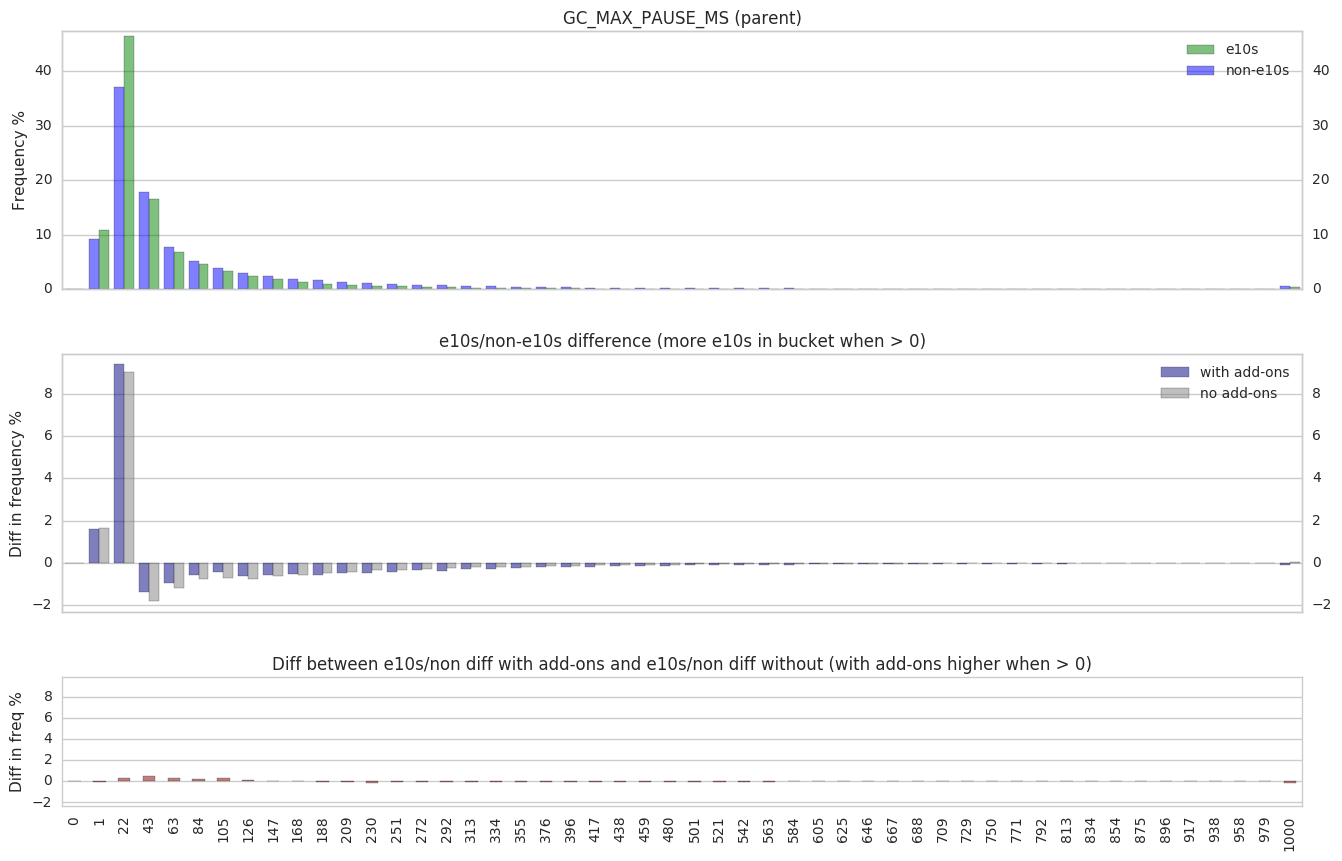

The probability that the distributions for GC_MAX_PAUSE_MS (parent) (with add-ons) are differing by chance is 0.000.


Comparison for CYCLE_COLLECTOR_MAX_PAUSE (with add-ons):

118822 non-e10s profiles have this histogram.
117469 e10s profiles have this histogram.
117469 e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


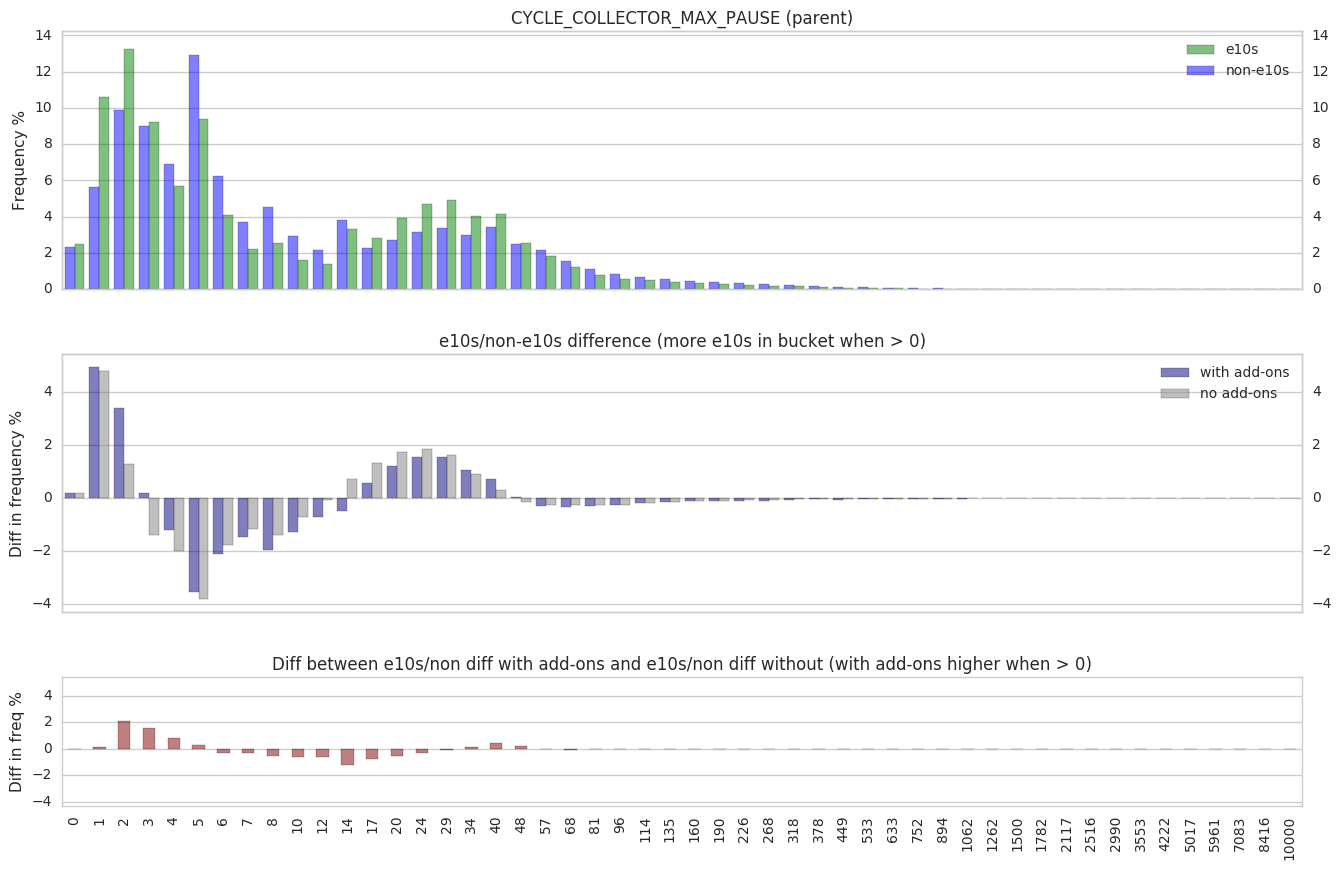

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (parent) (with add-ons) are differing by chance is 0.000.


Comparison for INPUT_EVENT_RESPONSE_MS (with add-ons):

126475 non-e10s profiles have this histogram.
124853 e10s profiles have this histogram.
124853 e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


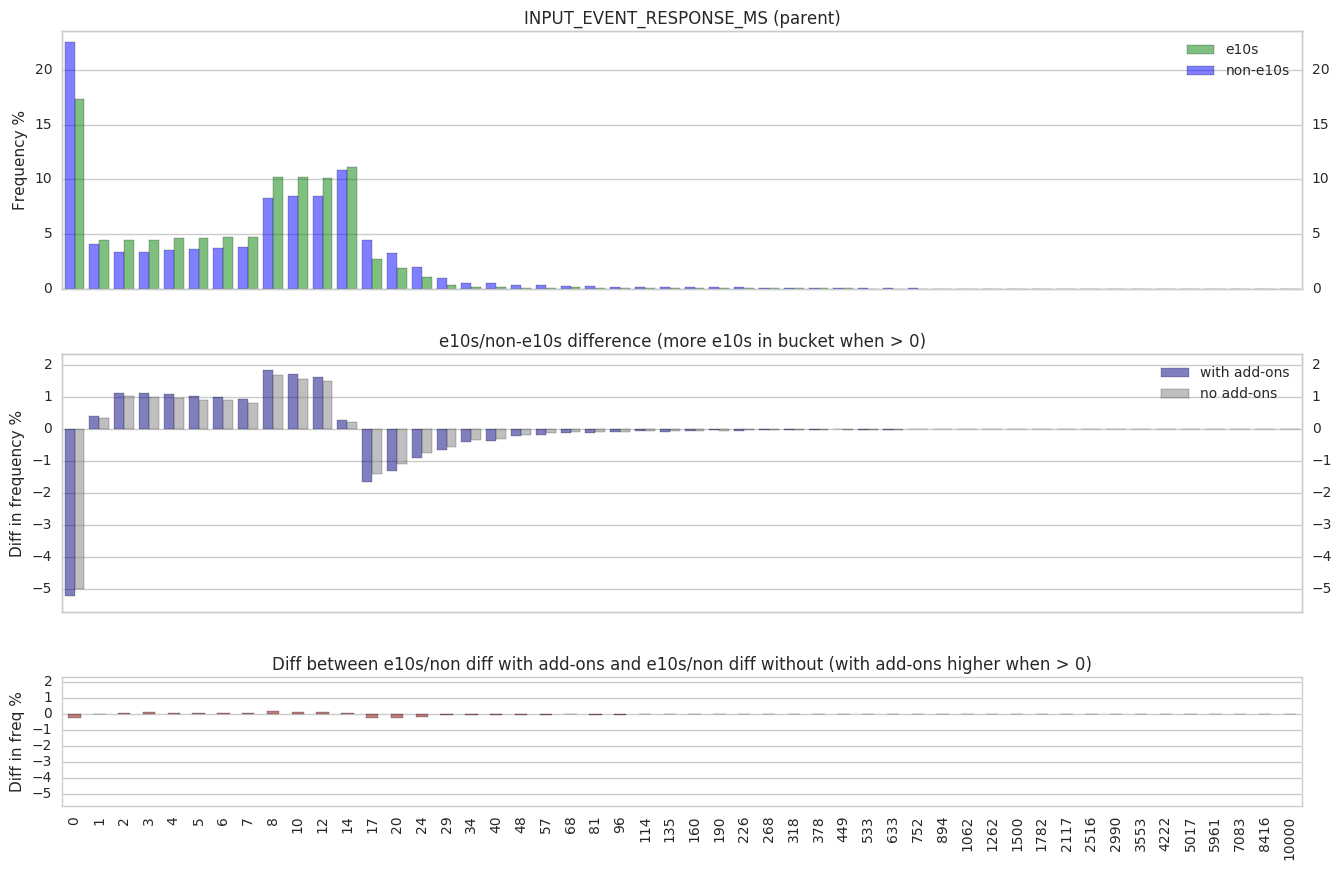

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (parent) (with add-ons) are differing by chance is 0.000.


In [37]:
compare_histograms(subset,  
                   "payload/histograms/GC_MAX_PAUSE_MS",
                   "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE",
                   "payload/histograms/INPUT_EVENT_RESPONSE_MS")

## 1.4 Page load

Comparison for FX_PAGE_LOAD_MS (with add-ons):

123259 non-e10s profiles have this histogram.
124192 e10s profiles have this histogram.
124192 e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


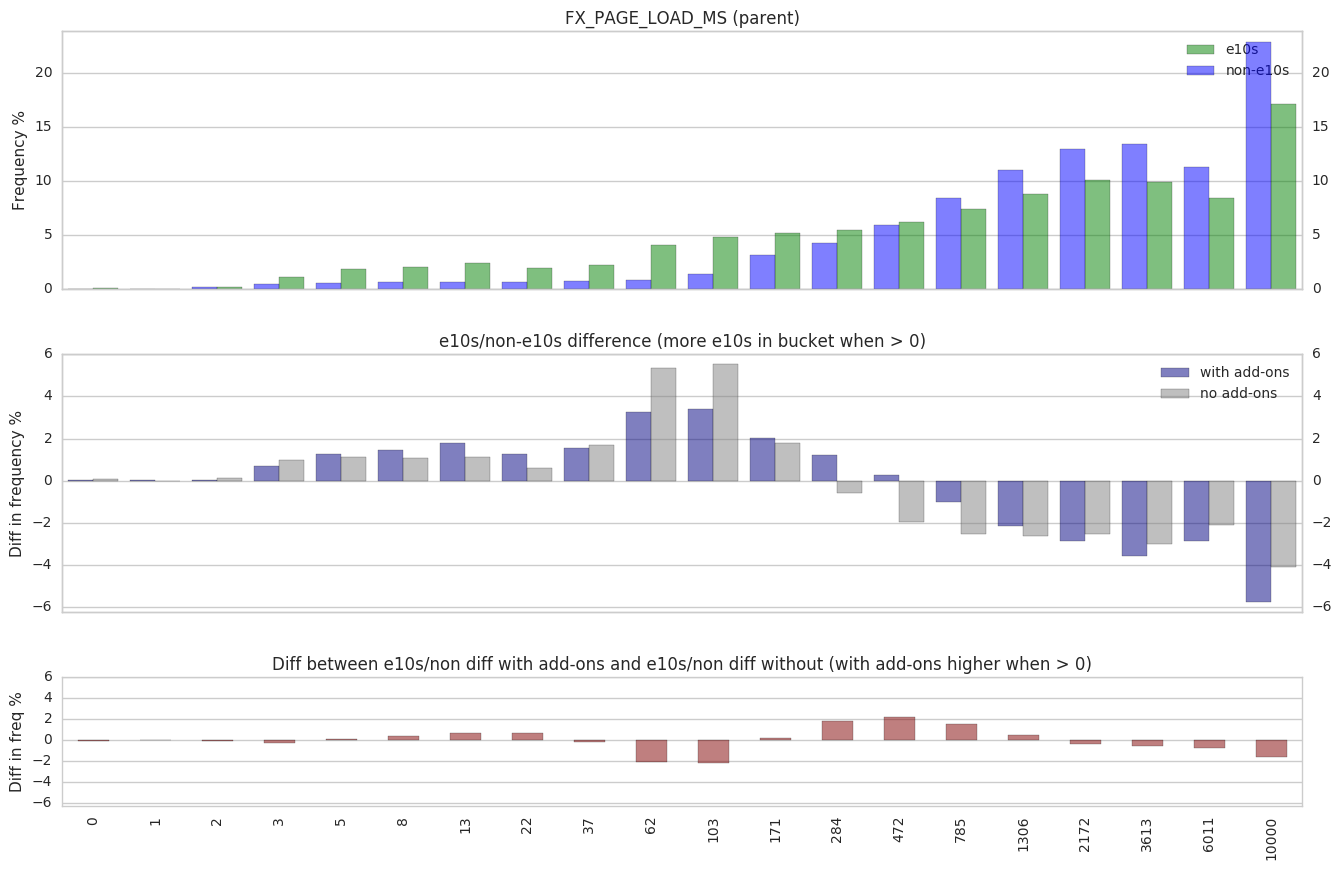

The probability that the distributions for FX_PAGE_LOAD_MS (parent) (with add-ons) are differing by chance is 0.000.


In [38]:
compare_histograms(subset, "payload/histograms/FX_PAGE_LOAD_MS")

## 1.5 Startup/shutdown time

In [39]:
simple = pd.DataFrame(get_pings_properties(subset, [
    "payload/simpleMeasurements/firstPaint",
    "payload/simpleMeasurements/sessionRestored",
    "payload/simpleMeasurements/shutdownDuration",
    "e10s",
    "addons"]).collect())

eSimple = simple[simple["addons"] & simple["e10s"]]
nSimple = simple[simple["addons"] & ~simple["e10s"]]
eSimple_std = simple[~simple["addons"] & simple["e10s"]]
nSimple_std = simple[~simple["addons"] & ~simple["e10s"]]

len(eSimple), len(nSimple), len(eSimple_std), len(nSimple_std)

(124874, 126503, 125149, 126163)

In [40]:
compare_scalars("firstPaint time",
                eSimple["payload/simpleMeasurements/firstPaint"],
                nSimple["payload/simpleMeasurements/firstPaint"],
                eSimple_std["payload/simpleMeasurements/firstPaint"],
                nSimple_std["payload/simpleMeasurements/firstPaint"],
                "ms")

Comparison for firstPaint time (ms) (with add-ons):

- Median with e10s is 127 ms different from median without e10s.
- This is a relative difference of 2.7%.
- E10s group median is 4888, non-e10s group median is 4761.

The probability of this difference occurring purely by chance is 0.000.

For cohorts with no add-ons, median with e10s is 166 ms (4.1%) different from median without
- This is a relative difference of 4.1%.
- E10s group median is 4236, non-e10s group median is 4070.


In [41]:
compare_scalars("sessionRestored time",
                eSimple["payload/simpleMeasurements/sessionRestored"],
                nSimple["payload/simpleMeasurements/sessionRestored"],
                eSimple_std["payload/simpleMeasurements/sessionRestored"],
                nSimple_std["payload/simpleMeasurements/sessionRestored"],
               "ms")

Comparison for sessionRestored time (ms) (with add-ons):

- Median with e10s is -112 ms different from median without e10s.
- This is a relative difference of -1.7%.
- E10s group median is 6295, non-e10s group median is 6407.

The probability of this difference occurring purely by chance is 0.000.

For cohorts with no add-ons, median with e10s is -70 ms (-1.3%) different from median without
- This is a relative difference of -1.3%.
- E10s group median is 5388, non-e10s group median is 5458.


In [42]:
compare_scalars("shutdownDuration time",
                eSimple["payload/simpleMeasurements/shutdownDuration"],
                nSimple["payload/simpleMeasurements/shutdownDuration"],
                eSimple_std["payload/simpleMeasurements/shutdownDuration"],
                nSimple_std["payload/simpleMeasurements/shutdownDuration"],
               "ms")

Comparison for shutdownDuration time (ms) (with add-ons):

- Median with e10s is 39.5 ms different from median without e10s.
- This is a relative difference of 2.7%.
- E10s group median is 1486, non-e10s group median is 1446.

The probability of this difference occurring purely by chance is 0.000.

For cohorts with no add-ons, median with e10s is 47 ms (3.9%) different from median without
- This is a relative difference of 3.9%.
- E10s group median is 1248, non-e10s group median is 1201.


## 1.6 Scrolling

Comparison for FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (with add-ons):

87276 non-e10s profiles have this histogram.
7402 e10s profiles have this histogram.
7402 e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


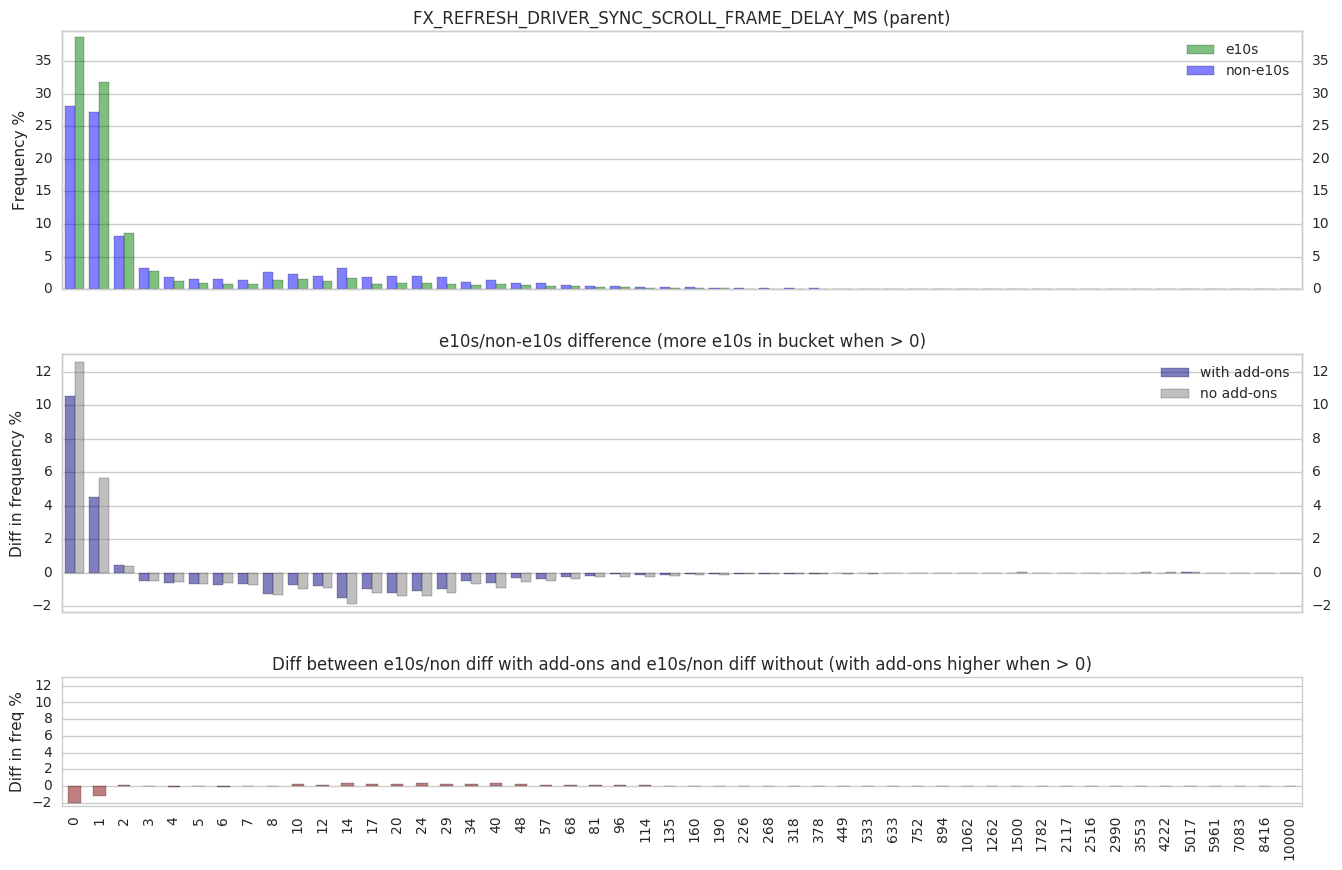

The probability that the distributions for FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (parent) (with add-ons) are differing by chance is 0.000.


In [43]:
compare_histograms(subset, "payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS")

## 1.7 Plugin jank

The plugin jank histograms are keyed by plugin. We find the most common plugin across all three histograms, and make the comparisons for that plugin.

In [44]:
plugin_hist = ["BLOCKED_ON_PLUGIN_MODULE_INIT_MS",
               "BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS",
               "BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS"]

def get_hist_plugins(ping):
    """ Find the keys used across all plugin histograms. """
    khist = ping.get("payload", {}).get("keyedHistograms", {})
    plugin_keys = []
    for h in plugin_hist:
        if h in khist:
            plugin_keys += map(lambda k: (h, k), khist[h].keys())
    return plugin_keys
        
plugin_hist_counts = subset.flatMap(get_hist_plugins).countByValue()
## Find the most commonly occurring plugin for each histogram.
top_plugins = {}
for h in plugin_hist:
    pl_for_hist = [(pl, n) for ((hist, pl), n) in plugin_hist_counts.iteritems()
                       if hist == h]
    top_plugins[h] = sorted(pl_for_hist, key=lambda (pl, n): n, reverse=True)[0]

for hist, (pl, n) in top_plugins.iteritems():
    print("Top plugin for {}: '{}'".format(hist, pl))

Top plugin for BLOCKED_ON_PLUGIN_MODULE_INIT_MS: 'Shockwave Flash24.0.0.194'
Top plugin for BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS: 'Shockwave Flash24.0.0.194'
Top plugin for BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS: 'Shockwave Flash24.0.0.194'


In [45]:
top_plugin = sorted(top_plugins.items(), key=lambda (pl, n): n, reverse=True)[0]
top_plugin = top_plugin[1][0]
print("Comparing plugin jank for '{}' (overall top plugin)".format(top_plugin))

Comparing plugin jank for 'Shockwave Flash24.0.0.194' (overall top plugin)


Comparison for [BLOCKED_ON_PLUGIN_MODULE_INIT_MS](https://dxr.mozilla.org/mozilla-central/search?q=BLOCKED_ON_PLUGIN_MODULE_INIT_MS+file%3AHistograms.json&redirect=true)/Shockwave Flash24.0.0.194 (with add-ons):

16722 non-e10s profiles have this histogram.
16293 e10s profiles have this histogram.
16293 e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


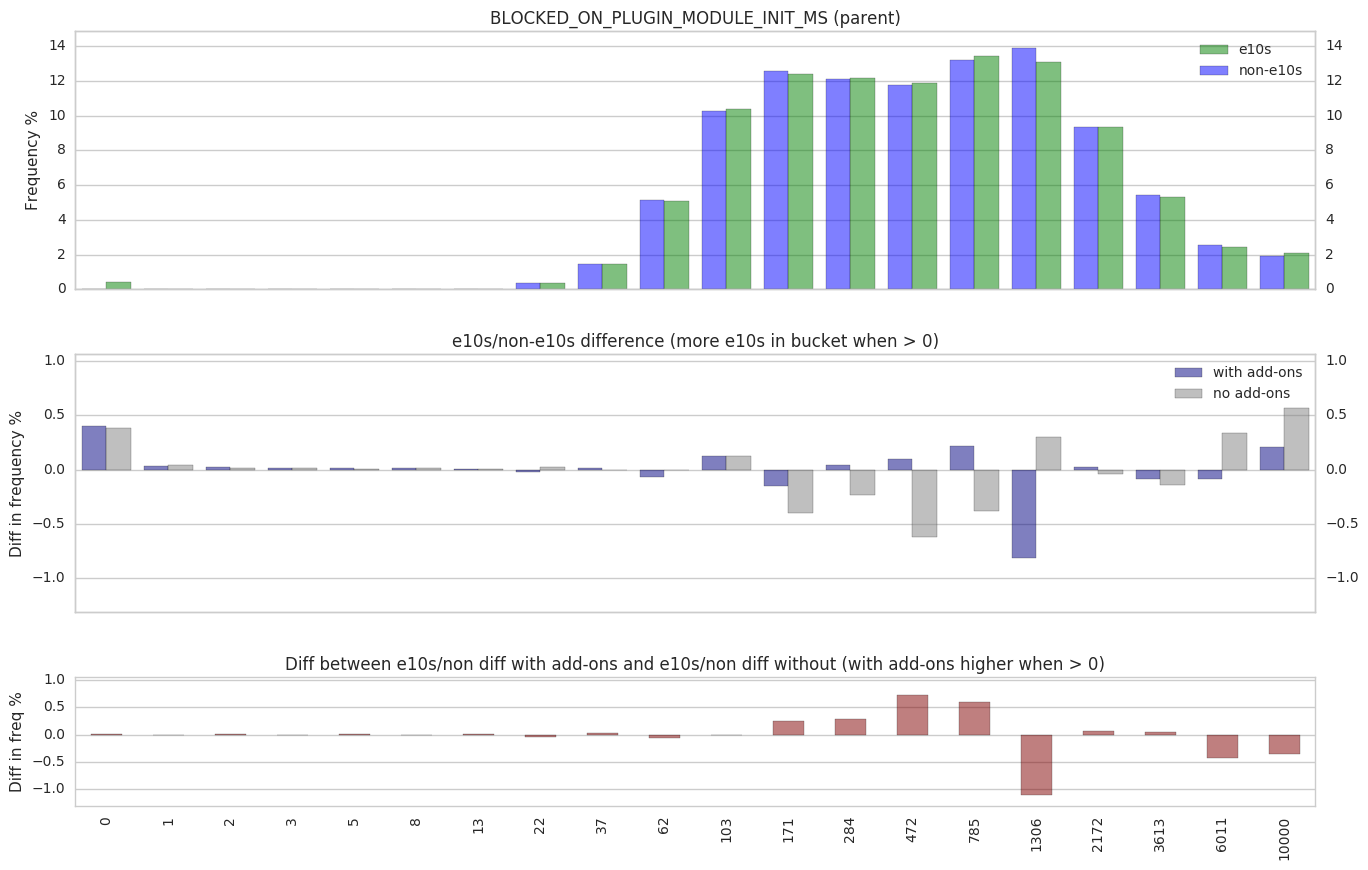

The probability that the distributions for BLOCKED_ON_PLUGIN_MODULE_INIT_MS (parent) (with add-ons) are differing by chance is 0.000.


Comparison for [BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS](https://dxr.mozilla.org/mozilla-central/search?q=BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS+file%3AHistograms.json&redirect=true)/Shockwave Flash24.0.0.194 (with add-ons):

16722 non-e10s profiles have this histogram.
No e10s profiles have this histogram.


Comparison for [BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS](https://dxr.mozilla.org/mozilla-central/search?q=BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS+file%3AHistograms.json&redirect=true)/Shockwave Flash24.0.0.194 (with add-ons):

16636 non-e10s profiles have this histogram.
No e10s profiles have this histogram.


In [46]:
compare_histograms(subset,
                   "payload/keyedHistograms/BLOCKED_ON_PLUGIN_MODULE_INIT_MS/{}".format(top_plugin),
                   "payload/keyedHistograms/BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS/{}".format(top_plugin),
                   "payload/keyedHistograms/BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS/{}".format(top_plugin))

## 1.8 Memory usage

Comparison for MEMORY_TOTAL (with add-ons):

126440 non-e10s profiles have this histogram.
124015 e10s profiles have this histogram.
124015 e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


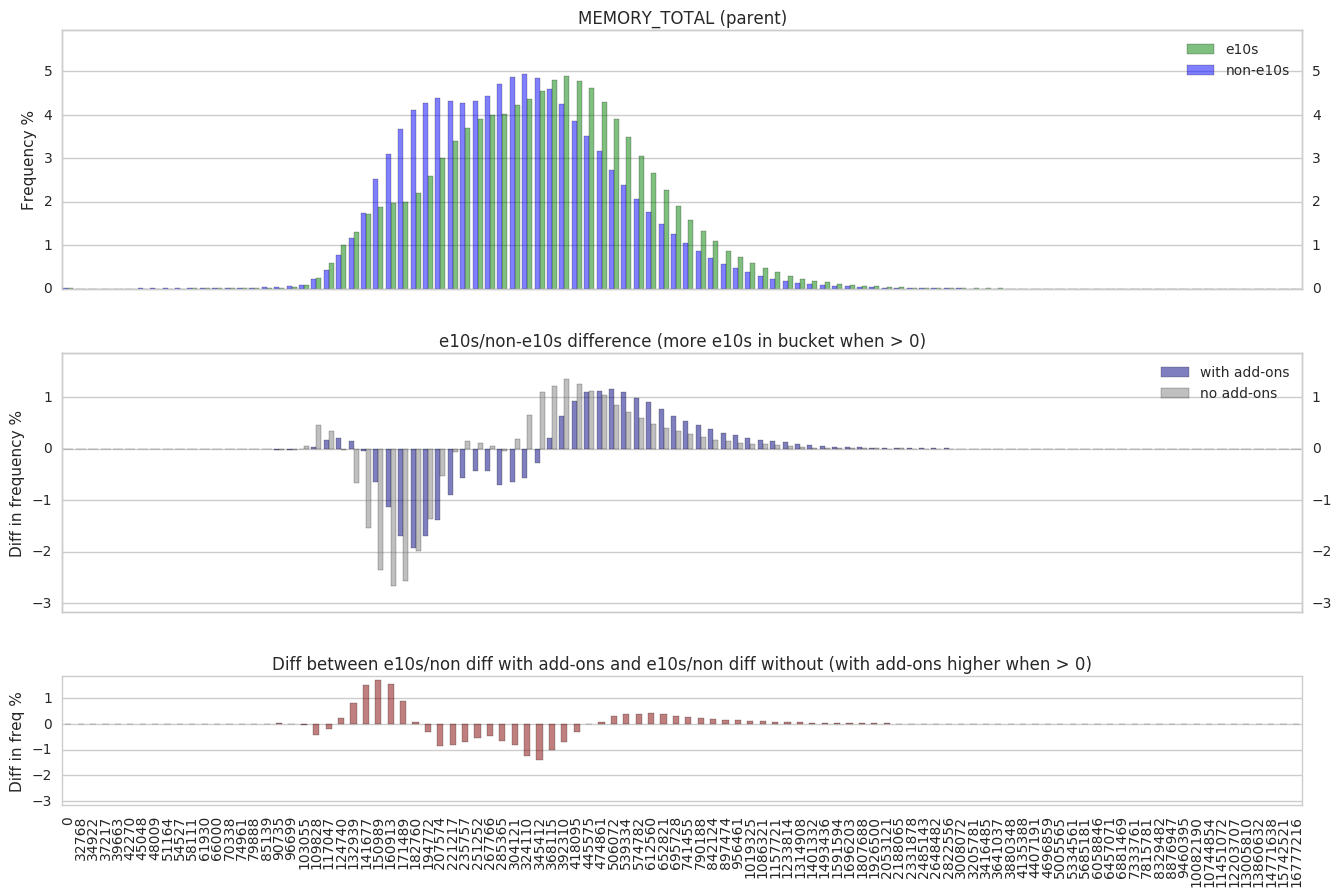

The probability that the distributions for MEMORY_TOTAL (parent) (with add-ons) are differing by chance is 0.000.


Comparison for MEMORY_VSIZE_MAX_CONTIGUOUS (with add-ons):

124169 non-e10s profiles have this histogram.
122514 e10s profiles have this histogram.
122514 e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


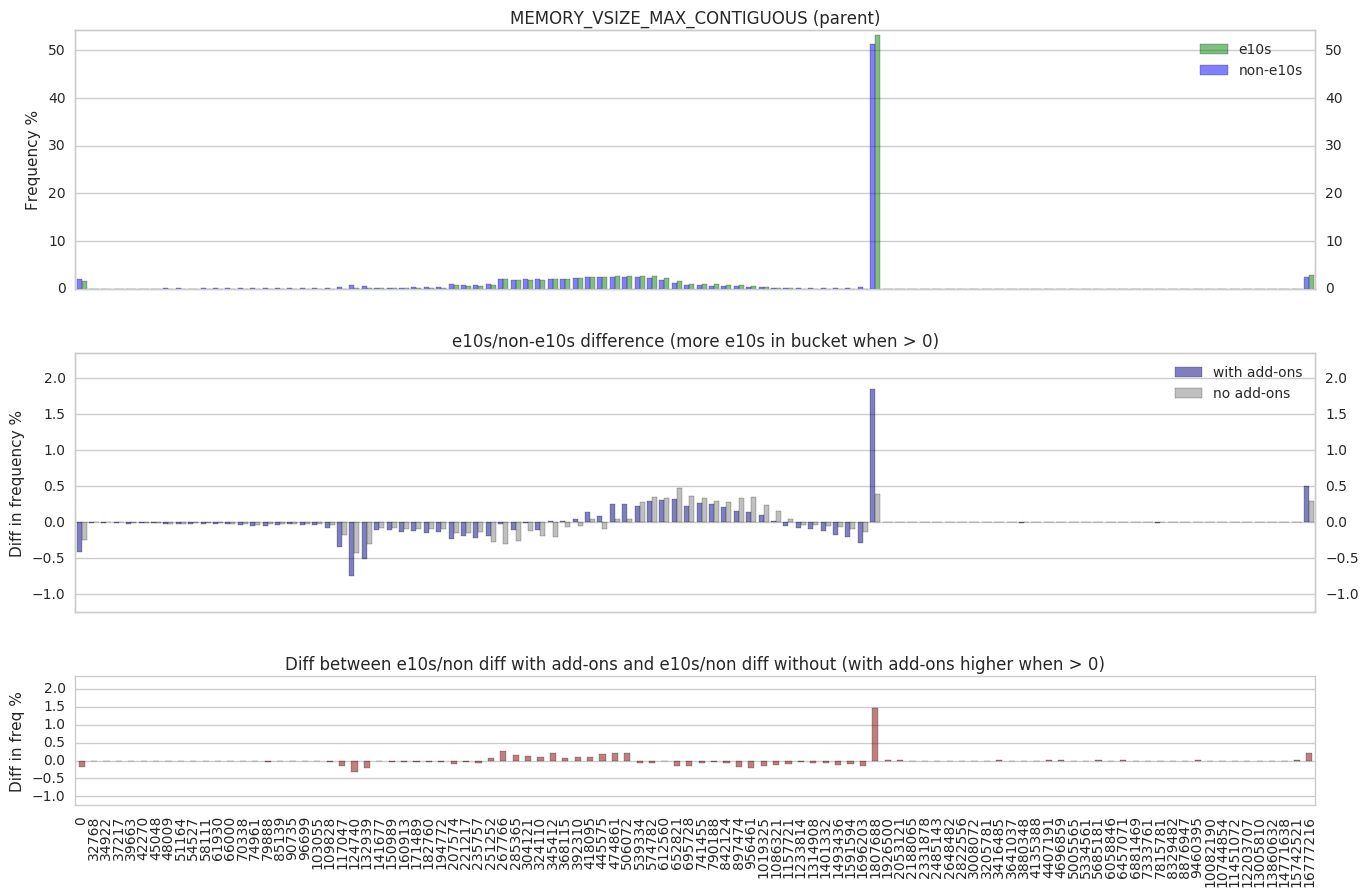

The probability that the distributions for MEMORY_VSIZE_MAX_CONTIGUOUS (parent) (with add-ons) are differing by chance is 0.000.


In [47]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_TOTAL",
                   "payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS")

## 1.9 UI Smoothness

__Note__: `FX_TAB_SWITCH_TOTAL_MS` was renamed to `FX_TAB_SWITCH_TOTAL_E10S_MS` for e10s profiles.

In [48]:
def fix_hist(ping):
    """ Rename the histogram for e10s profiles. """
    hist = ping.get("payload", {}).get("histograms", {})
    if "FX_TAB_SWITCH_TOTAL_E10S_MS" in hist and "FX_TAB_SWITCH_TOTAL_MS" not in hist:
        hist["FX_TAB_SWITCH_TOTAL_MS"] = hist["FX_TAB_SWITCH_TOTAL_E10S_MS"]
    return ping

subset_fixed = subset.map(fix_hist)

Comparison for FX_TAB_SWITCH_TOTAL_MS (with add-ons):

79035 non-e10s profiles have this histogram.
77320 e10s profiles have this histogram.
77320 e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


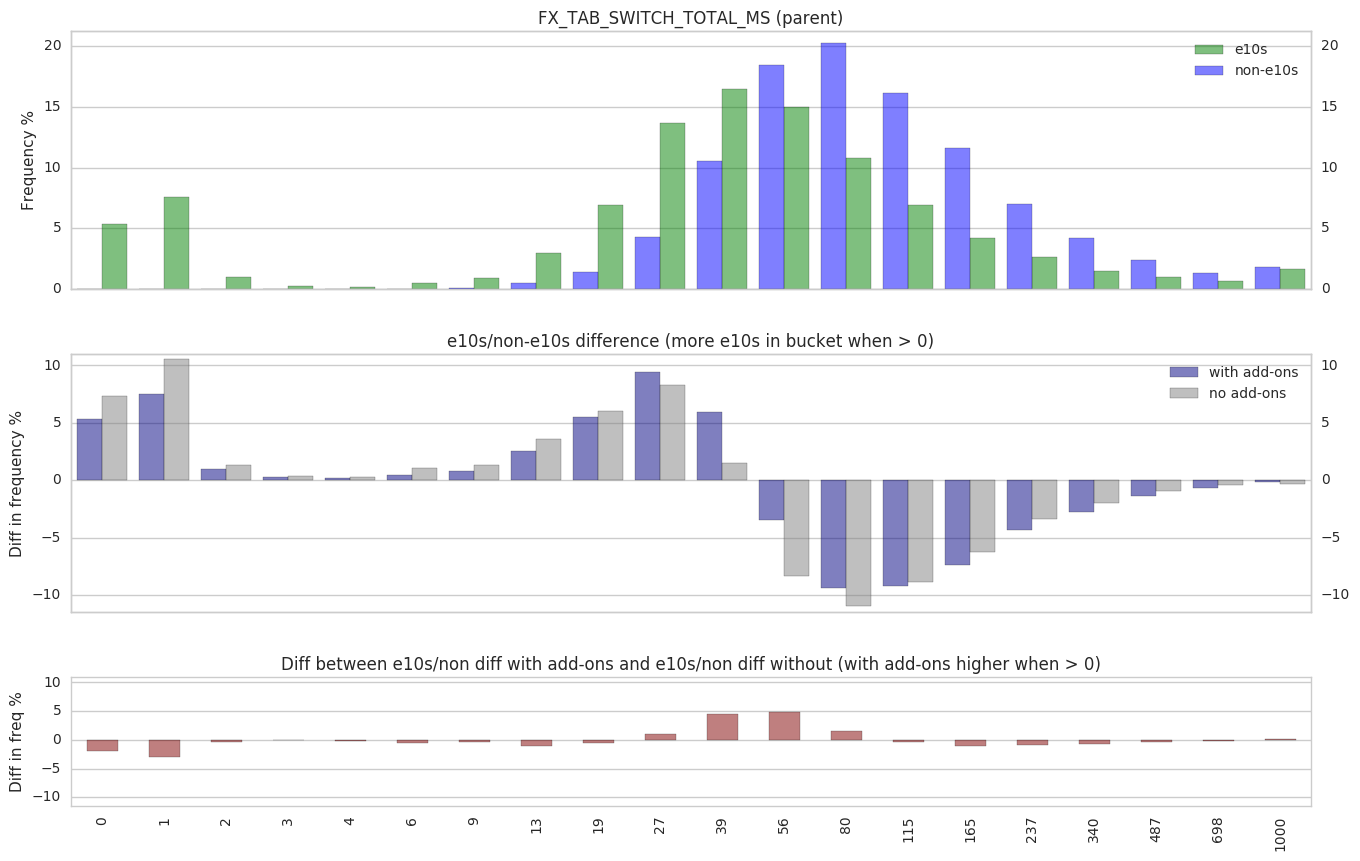

The probability that the distributions for FX_TAB_SWITCH_TOTAL_MS (parent) (with add-ons) are differing by chance is 0.000.


In [49]:
compare_histograms(subset_fixed, "payload/histograms/FX_TAB_SWITCH_TOTAL_MS")

## 1.11 Slow Scripts

In [50]:
compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_PAGE_COUNT")

Comparison for count histogram SLOW_SCRIPT_PAGE_COUNT (with add-ons):

2304 non-e10s profiles have this histogram.
560 e10s profiles have this histogram.

Comparison for SLOW_SCRIPT_PAGE_COUNT per hour (with add-ons):

- Median with e10s is -0.0338 units different from median without e10s.
- This is a relative difference of -10.8%.
- E10s group median is 0.2799, non-e10s group median is 0.3138.

The probability of this difference occurring purely by chance is 0.289.

For cohorts with no add-ons, median with e10s is -0.0217 units (-6.4%) different from median without
- This is a relative difference of -6.4%.
- E10s group median is 0.3159, non-e10s group median is 0.3376.


## Slow Add-ons

In [51]:
def has_slow_scripts(histograms):
    hists = json.loads(histograms)
    return "SLOW_SCRIPT_PAGE_COUNT" in hists

has_slow_scripts = fun.udf(has_slow_scripts, st.BooleanType())

ss = addons_exp_dataset.filter(has_slow_scripts('histograms'))
ss.count()

28009

In [52]:
print "For profiles having slow scripts with add-ons and E10s ,"
test = get_top_addons(ss, "e10sCohort like 'addons%test%'", n_top=None)
test.head(10)

For profiles having slow scripts with add-ons and E10s ,
There were 1,079 distinct add-ons installed across the e10sCohort like 'addons%test%' cohort.


,guid,name,version,is_system,n_installs,pct_installed
1,aushelper@mozilla.org,Application Update Service Helper,1.0,True,2575,99.536142
2,webcompat@mozilla.org,Web Compat,1.0,True,2572,99.420178
3,e10srollout@mozilla.org,Multi-process staged rollout,1.7,True,2572,99.420178
4,firefox@getpocket.com,Pocket,1.0.5,True,2572,99.420178
5,diagnostics@mozilla.org,Diagnostics,1.0,True,2334,90.220332
6,disableSHA1rollout@mozilla.org,SHA-1 deprecation staged rollout,1.0,True,2026,78.314650
7,{4ED1F68A-5463-4931-9384-8FFF5ED91D92},McAfee WebAdvisor,5.0.360.0,False,288,11.132586
8,{d10d0bf8-f5b5-c8b4-a8b2-2b9879e08c5d},Adblock Plus,2.8.2,False,279,10.784693
9,helper-sig@savefrom.net,SaveFrom.net - helper,7.7,False,210,8.117511
10,{b9db16a4-6edc-47ec-a1f4-b86292ed211d},Video DownloadHelper,6.2.0,False,139,5.373019


In [53]:
print "For profiles having slow scripts with add-ons and no E10s,"
control = get_top_addons(ss, "e10sCohort like 'addons%control%'", n_top=None)
control.head(10)

For profiles having slow scripts with add-ons and no E10s,
There were 2,014 distinct add-ons installed across the e10sCohort like 'addons%control%' cohort.


,guid,name,version,is_system,n_installs,pct_installed
1,aushelper@mozilla.org,Application Update Service Helper,1.0,True,9981,99.750150
2,webcompat@mozilla.org,Web Compat,1.0,True,9974,99.680192
3,e10srollout@mozilla.org,Multi-process staged rollout,1.7,True,9951,99.450330
4,firefox@getpocket.com,Pocket,1.0.5,True,9941,99.350390
5,diagnostics@mozilla.org,Diagnostics,1.0,True,9322,93.164102
6,disableSHA1rollout@mozilla.org,SHA-1 deprecation staged rollout,1.0,True,8428,84.229462
7,{d10d0bf8-f5b5-c8b4-a8b2-2b9879e08c5d},Adblock Plus,2.8.2,False,1388,13.871677
8,helper-sig@savefrom.net,SaveFrom.net - helper,7.7,False,634,6.336198
9,_65Members_@download.fromdoctopdf.com,FromDocToPDF,7.600.10.55137,False,578,5.776534
10,{b9db16a4-6edc-47ec-a1f4-b86292ed211d},Video DownloadHelper,6.2.0,False,574,5.736558


# Hangs

In [54]:
parent_hangs_by_group = subset.map(lambda x: {'parent_hangs':x.get('parent_hangs_per_minute', -1), 
                                              'cohort': x['cohort']})

child_hangs_by_group = subset.map(lambda x: {'child_hangs':x.get('child_hangs_per_minute', -1), 
                                              'cohort': x.get('cohort', {})})

In [55]:
parent_hangs = pd.DataFrame(parent_hangs_by_group.filter(lambda x: x.get('parent_hangs') >= 0).collect())

# filter out control cohorts for child processes
child_hangs = pd.DataFrame(child_hangs_by_group.filter(lambda x: x.get('child_hangs') >= 0)
                                               .filter(lambda x: x.get('cohort', {}) in \
                                                                (ADDONS_TEST_COHORT, 'test'))\
                                               .collect())


Below we look at hangs per minute for parent and child (main and content). Using natural log scale to make plots more digestable, however the raw (unlogged) medians are printed per cohort before each plot.

# Profiles with parent hangs in each cohort:
                               parent_hangs
cohort                                     
addons-set51alladdons-control        126129
addons-set51alladdons-test           124483
control                              123410
test                                 123478

Median parent hangs per minute by group:
                               parent_hangs
cohort                                     
addons-set51alladdons-control      3.778614
addons-set51alladdons-test         1.105464
control                            2.867998
test                               0.872727


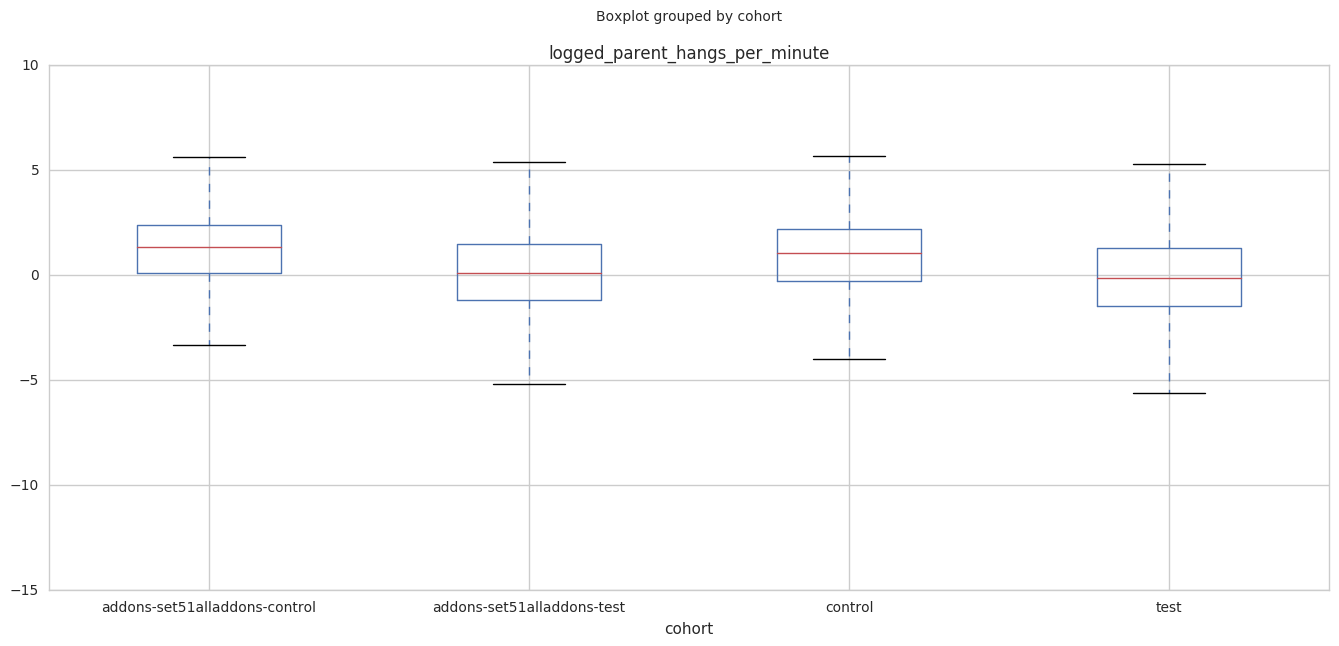

In [56]:
print "# Profiles with parent hangs in each cohort:"
print parent_hangs.groupby('cohort').count()
print "\nMedian parent hangs per minute by group:"
print parent_hangs.groupby('cohort').median()

parent_hangs['logged_parent_hangs_per_minute'] = np.log(parent_hangs['parent_hangs'])
parent_hangs.boxplot('logged_parent_hangs_per_minute', by='cohort')

# Profiles with child hangs in each cohort:
                            child_hangs
cohort                                 
addons-set51alladdons-test       115069
test                             110525

Median child hangs per minute by group:
                            child_hangs
cohort                                 
addons-set51alladdons-test     2.884072
test                           1.931138


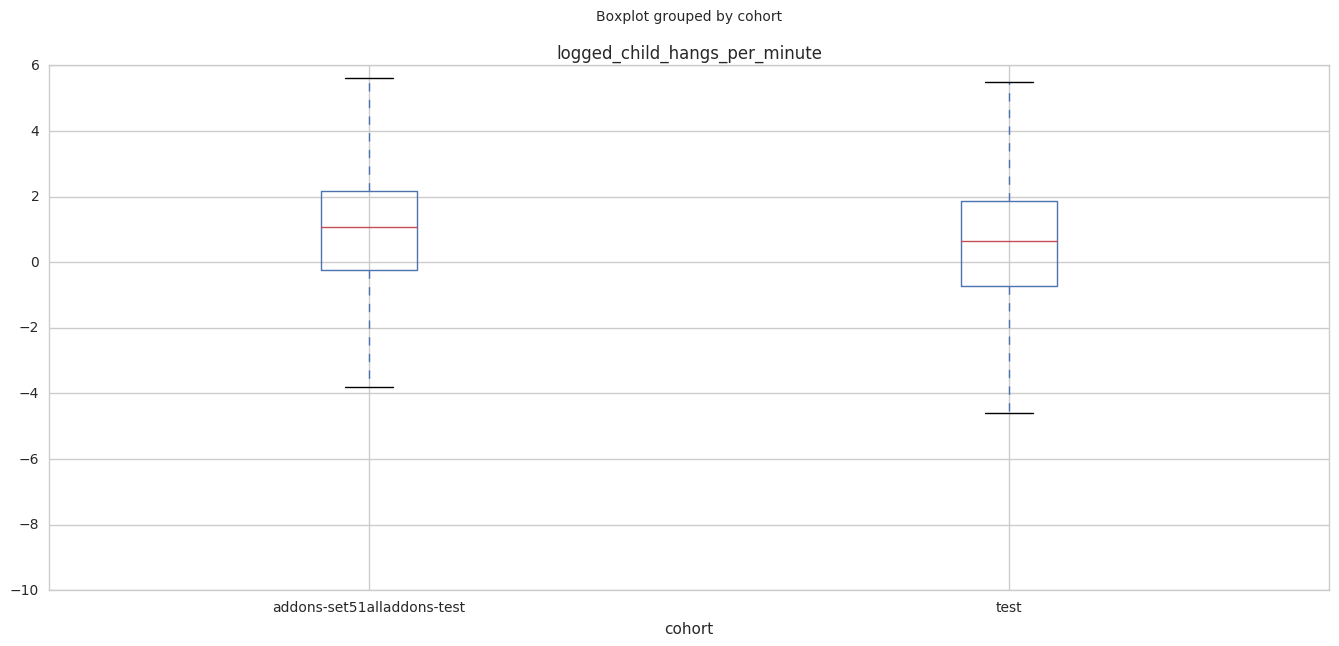

In [57]:
print "# Profiles with child hangs in each cohort:"
print child_hangs.groupby('cohort').count()
print "\nMedian child hangs per minute by group:"
print child_hangs.groupby('cohort').median()

child_hangs["logged_child_hangs_per_minute"] = np.log(child_hangs['child_hangs'])
child_hangs.boxplot('logged_child_hangs_per_minute', by='cohort')

# Stacks

adapted from previous analysis: https://github.com/mozilla/e10s_analyses/blob/1e2f4650d2b3ed5232a1459026fe8865e69dbf5c/beta/old/e10s_top_hang_stacks.ipynb

# View Stacks Tables [here](https://metrics.mozilla.com/protected/bmiroglio/addons/e10s/_site/stacks.html)

The following code produces the stacks tables, nothing more is displayed in the notebook.

In [58]:
def get_stacks(subset):
    def yield_ping_stacks(ping):
        for thread in ping["payload"]["threadHangStats"]:
            if thread["name"] != "Gecko":
                continue
            for hang in thread["hangs"]:
                if not hang["stack"]:
                    continue
                values = hang["histogram"]["values"]
                histogram = pd.Series(values.values(), index=map(int, values.keys())).sort_index()
                min_ms = 100
                over_min_ms_count = histogram[histogram.index > min_ms].sum()
                yield (tuple(hang["stack"]), over_min_ms_count)
    return subset.flatMap(yield_ping_stacks).reduceByKey(lambda a, b: a + b).collectAsMap()

In [59]:
addons_e10s = get_stacks(subset.filter(lambda x: x['cohort'] == ADDONS_TEST_COHORT))
addons_no_e10s = get_stacks(subset.filter(lambda x: x['cohort'] == ADDONS_CONTROL_COHORT))
e10s = get_stacks(subset.filter(lambda x: x['cohort'] == 'test'))
no_e10s = get_stacks(subset.filter(lambda x: x['cohort'] == 'control'))

In [60]:
def get_top_stacks_per_group(c1, c2, c3, c4, count, 
                             names=['Addons/E10s', 'Addons/NoE10s', 'NoAddons/E10s', 'NoAddons/NoE10s']):
    '''
    Takes the top <count> stacks per group in c1...4, ordered by
    the ordering of the <names> list
    
    returns pandas DF indexed by the stack type
    '''
    c1_total_count = sum(c1.values())
    c2_total_count = sum(c2.values())
    c3_total_count = sum(c3.values())
    c4_total_count = sum(c4.values())
    result = []
    index = []
    for c, c1_stack_count in Counter(c1).most_common(count):
        row = {}
        c2_stack_count = c2.get(c, 0)
        c3_stack_count = c3.get(c, 0)
        c4_stack_count = c4.get(c, 0)
        row = {names[0]: 100.0 * c1_stack_count / c1_total_count,
               names[1]: 100.0 * c2_stack_count / c2_total_count,
               names[2]: 100.0 * c3_stack_count / c3_total_count,
               names[3]:100.0 * c4_stack_count / c4_total_count}
        index.append("<br>".join(reversed(c)))
        result.append(row)
    
    df = pd.DataFrame(result)[names]
    df.index = index
    return df.applymap(lambda x: '{:.2f}'.format(float(x)) + '%')

def heat_map_df(df, color='red', css='background', null_color='white'):
    '''
    Colors in background of a percentage table
    based on value.
    
    returns stylized dataframe (different from pd.Dataframe)
    '''
    color = Color(color)
    dfmax = max(df.applymap(lambda x: float(x.split('%')[0])).max())
    n_colors = int(math.ceil(dfmax))
    gradient = list(reversed(list(color.range_to(Color(null_color),n_colors+1))))
    
    gradient_map = {}
    for i in range(n_colors+1):
        gradient_map[i] = gradient[i]
    
    css_style = lambda x: "%s: %s" % \
       (css, gradient_map[int(math.ceil(float(x.split('%')[0])))])
    df1 = df.style.applymap(css_style)
    return df1

def heatmapify(df):
    '''
    Takes a pandas df and applies heatmap function to cells
    with some cleaner css
    
    returns raw html
    '''


    css_header = '''
    
    <style  type="text/css" >
    
    table {
        font-family:Arial, Helvetica, sans-serif;
        font-size:12px;
        background:#eaebec;
        margin:0 auto;
        border:#ccc 1px solid;

        -moz-border-radius:3px;
        -webkit-border-radius:3px;
        border-radius:3px;

    }

    table th {
        padding:21px 25px 22px 25px;
        border-top:1px solid #fafafa;
        border-bottom:1px solid #e0e0e0;
    }

    table th:first-child {
        text-align: left;
        padding-left:20px;
    }


    table tr {
        text-align: center;
        padding-left:20px;
    }

    table td {
        padding:18px;
        border-top: 1px solid #ffffff;
        border-bottom:1px solid #e0e0e0;
        border-left: 1px solid #e0e0e0;

    }
    
    tr:hover{
        background-color: #CBCDCF;
    }
    '''
    formatted_table = css_header + '\n' + heat_map_df(df).render()\
                                          .split('<style  type="text/css" >')[1]
    return formatted_table


In [61]:
AE = get_top_stacks_per_group(addons_e10s, addons_no_e10s, e10s, no_e10s,25,
        names = ['Addons/E10s', 'Addons/NoE10s', 'NoAddons/E10s', 'NoAddons/NoE10s'])
ANE = get_top_stacks_per_group(addons_no_e10s, addons_e10s, e10s, no_e10s,25,
        names = ['Addons/NoE10s', 'Addons/E10s', 'NoAddons/E10s', 'NoAddons/NoE10s'])
NAE = get_top_stacks_per_group(e10s, addons_e10s, addons_no_e10s, no_e10s,25,
        names = ['NoAddons/E10s', 'Addons/E10s', 'Addons/NoE10s', 'NoAddons/NoE10s'])
NANE = get_top_stacks_per_group(no_e10s, e10s, addons_e10s, addons_no_e10s,25,
        names = ['NoAddons/NoE10s', 'NoAddons/E10s', 'Addons/E10s', 'Addons/NoE10s'])

In [62]:
cohorts = (AE, ANE, NAE, NANE)
filenames = ('ae.html', 'ane.html', 'nae.html', 'nane.html')
for i in range(4):
    html = heatmapify(cohorts[i])
    with open(filenames[i], 'w') as f:
        f.write(html)